In [1]:
## Primrose, Lab2  IST718

%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
import statsmodels.api as sm
from math import sqrt
from pandas import DataFrame
from pandas.core.resample import TimeGrouper
from scipy.stats import boxcox
import patsy  # translate model specification into design matrices




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# OBTAIN - THERE ARE MANY WAYS TO READ INFO INTO COLAB
# THIS IS ONE - ASSUMES YOU HAVE A PY FILE THAT YOU WANT TO ACCESS
# WITHIN COLAB - IN THIS CASE THE FILE IS: 
# evaluate_classifier.py

from google.colab import files
import io

uploaded = files.upload()

# USE THE CHOOSE FILES BUTTON TO OPEN UP NAVIGATION TO DESIRED FILE

Saving Zip_Zhvi_SingleFamilyResidence.csv to Zip_Zhvi_SingleFamilyResidence.csv


In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
drive_path = '/content/gdrive/My Drive/'


In [5]:
!ls

gdrive	sample_data  Zip_Zhvi_SingleFamilyResidence.csv


In [6]:
# OBTAIN - MANY WAYS TO GET DATA - THIS IS ONE

series1 = pd.read_csv('Zip_Zhvi_SingleFamilyResidence.csv')
series1.head()



,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,...,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1524562.0,1525605.0,1525955.0,1528604.0,1527843.0,1530509.0,1525013.0,1531236.0,1532307.0,1543260.0,1534946.0,1527048.0,1508495.0,1498638.0,1494872.0,1487969.0,1480591.0,1471324.0,1462476.0,1456223.0,1448110.0,1446622.0,1451579.0,1452858.0,1453112.0,1439554.0,1426900.0,1416568.0,1415022.0,1414474.0,1413747.0,1405862.0,1402547.0,1390420.0,1381621.0,1375725.0,1374714.0,1381453.0,1385737.0,1389268.0
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,364892.0,364162.0,363605.0,362963.0,361660.0,361342.0,360662.0,361804.0,363561.0,366592.0,370077.0,372842.0,376806.0,380122.0,384081.0,385663.0,389062.0,389359.0,390182.0,388087.0,385729.0,381688.0,377848.0,376493.0,374914.0,375094.0,375012.0,378067.0,380789.0,386605.0,392801.0,...,958178.0,956528.0,951529.0,955244.0,958096.0,959882.0,958726.0,956879.0,958371.0,961171.0,960878.0,957985.0,958428.0,964051.0,969547.0,968807.0,968566.0,969572.0,972936.0,973010.0,972447.0,972684.0,975094.0,978629.0,981362.0,979667.0,976810.0,975419.0,975366.0,975741.0,974693.0,975616.0,975734.0,975251.0,974238.0,973104.0,971908.0,972038.0,973671.0,975642.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1669910.0,1661199.0,1639318.0,1622378.0,1613382.0,1611625.0,1609075.0,1611388.0,1615755.0,1619823.0,1609176.0,1597282.0,1581756.0,1572273.0,1573601.0,1578799.0,1585506.0,1587796.0,1591265.0,1596660.0,1598258.0,1596017.0,1595032.0,1592948.0,1590038.0,1576594.0,1562766.0,1552128.0,1545711.0,1540137.0,1528603.0,1514894.0,1502233.0,1492429.0,1486122.0,1480426.0,1476509.0,1478980.0,1479301.0,1474994.0
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,200475.0,200723.0,200526.0,199337.0,198200.0,197534.0,198298.0,197986.0,197333.0,196543.0,197444.0,199129.0,201687.0,202931.0,204207.0,206413.0,208870.0,210582.0,210250.0,212394.0,214904.0,217109.0,216177.0,214468.0,211736.0,210126.0,208420.0,207481.0,206443.0,206033.0,205925.0,...,331031.0,330770.0,331485.0,332276.0,332365.0,331319.0,331016.0,331256.0,331356.0,331165.0,331177.0,331223.0,332171.0,333159.0,333470.0,333247.0,333699.0,334667.0,335386.0,335194.0,335478.0,335777.0,336150.0,336558.0,336390.0,336776.0,336806.0,336869.0,336217.0,335679.0,335536.0,335878.0,335940.0,336092.0,336119.0,336083.0,336154.0,335860.0,336037.0,336483.0
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,546663.0,546231.0,545451.0,545391.0,543066.0,543084.0,542380.0,545254.0,548142.0,552660.0,557791.0,562238.0,566446.0,569659.0,573409.0,575403.0,581567.0,584316.0,587753.0,585957.0,583932.0,580996.0,578241.0,578355.0,580711.0,585527.0,591659.0,597955.0,604759.0,611702.0,620591.0,...,1173759.0,1175981.0,1174668.0,1182530.0,1188431.0,1192806.0,1193344.0,1191314.0,1192626.0,1196983.0,1199400.0,1199387.0,1202485.0,120

In [7]:
series1a = series1
series2 = series1

In [8]:
series1a.rename(columns = {'RegionName':'ZipCode'}, inplace = True) 

In [9]:
series1a.head()

,RegionID,SizeRank,ZipCode,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,...,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1524562.0,1525605.0,1525955.0,1528604.0,1527843.0,1530509.0,1525013.0,1531236.0,1532307.0,1543260.0,1534946.0,1527048.0,1508495.0,1498638.0,1494872.0,1487969.0,1480591.0,1471324.0,1462476.0,1456223.0,1448110.0,1446622.0,1451579.0,1452858.0,1453112.0,1439554.0,1426900.0,1416568.0,1415022.0,1414474.0,1413747.0,1405862.0,1402547.0,1390420.0,1381621.0,1375725.0,1374714.0,1381453.0,1385737.0,1389268.0
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,364892.0,364162.0,363605.0,362963.0,361660.0,361342.0,360662.0,361804.0,363561.0,366592.0,370077.0,372842.0,376806.0,380122.0,384081.0,385663.0,389062.0,389359.0,390182.0,388087.0,385729.0,381688.0,377848.0,376493.0,374914.0,375094.0,375012.0,378067.0,380789.0,386605.0,392801.0,...,958178.0,956528.0,951529.0,955244.0,958096.0,959882.0,958726.0,956879.0,958371.0,961171.0,960878.0,957985.0,958428.0,964051.0,969547.0,968807.0,968566.0,969572.0,972936.0,973010.0,972447.0,972684.0,975094.0,978629.0,981362.0,979667.0,976810.0,975419.0,975366.0,975741.0,974693.0,975616.0,975734.0,975251.0,974238.0,973104.0,971908.0,972038.0,973671.0,975642.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1669910.0,1661199.0,1639318.0,1622378.0,1613382.0,1611625.0,1609075.0,1611388.0,1615755.0,1619823.0,1609176.0,1597282.0,1581756.0,1572273.0,1573601.0,1578799.0,1585506.0,1587796.0,1591265.0,1596660.0,1598258.0,1596017.0,1595032.0,1592948.0,1590038.0,1576594.0,1562766.0,1552128.0,1545711.0,1540137.0,1528603.0,1514894.0,1502233.0,1492429.0,1486122.0,1480426.0,1476509.0,1478980.0,1479301.0,1474994.0
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,200475.0,200723.0,200526.0,199337.0,198200.0,197534.0,198298.0,197986.0,197333.0,196543.0,197444.0,199129.0,201687.0,202931.0,204207.0,206413.0,208870.0,210582.0,210250.0,212394.0,214904.0,217109.0,216177.0,214468.0,211736.0,210126.0,208420.0,207481.0,206443.0,206033.0,205925.0,...,331031.0,330770.0,331485.0,332276.0,332365.0,331319.0,331016.0,331256.0,331356.0,331165.0,331177.0,331223.0,332171.0,333159.0,333470.0,333247.0,333699.0,334667.0,335386.0,335194.0,335478.0,335777.0,336150.0,336558.0,336390.0,336776.0,336806.0,336869.0,336217.0,335679.0,335536.0,335878.0,335940.0,336092.0,336119.0,336083.0,336154.0,335860.0,336037.0,336483.0
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,546663.0,546231.0,545451.0,545391.0,543066.0,543084.0,542380.0,545254.0,548142.0,552660.0,557791.0,562238.0,566446.0,569659.0,573409.0,575403.0,581567.0,584316.0,587753.0,585957.0,583932.0,580996.0,578241.0,578355.0,580711.0,585527.0,591659.0,597955.0,604759.0,611702.0,620591.0,...,1173759.0,1175981.0,1174668.0,1182530.0,1188431.0,1192806.0,1193344.0,1191314.0,1192626.0,1196983.0,1199400.0,1199387.0,1202485.0,120890

In [ ]:
## SOME BASIC TIME DF MANIPULATION

# remove unwanted cols
# df = df.drop(columns = ['RegionID','City','State','Metro','CountyName','SizeRank'])
# convert zip code to col names
# df = df.set_index('ZipCode')
# transpose time series matrices
# df = df.T
# convert indices to date time
# df.index = pd.to_datetime(df.index)
# df.head()

In [10]:
## SOME BASIC TIME DF MANIPULATION
# remove unwanted cols
series1b= series1a.drop(columns = ['RegionID', 'RegionType', 'StateName', 'City', 'CountyName', 'SizeRank'])
series1b.head()

,ZipCode,State,Metro,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,...,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31
0,10025,NY,New York-Newark-Jersey City,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1524562.0,1525605.0,1525955.0,1528604.0,1527843.0,1530509.0,1525013.0,1531236.0,1532307.0,1543260.0,1534946.0,1527048.0,1508495.0,1498638.0,1494872.0,1487969.0,1480591.0,1471324.0,1462476.0,1456223.0,1448110.0,1446622.0,1451579.0,1452858.0,1453112.0,1439554.0,1426900.0,1416568.0,1415022.0,1414474.0,1413747.0,1405862.0,1402547.0,1390420.0,1381621.0,1375725.0,1374714.0,1381453.0,1385737.0,1389268.0
1,60657,IL,Chicago-Naperville-Elgin,364892.0,364162.0,363605.0,362963.0,361660.0,361342.0,360662.0,361804.0,363561.0,366592.0,370077.0,372842.0,376806.0,380122.0,384081.0,385663.0,389062.0,389359.0,390182.0,388087.0,385729.0,381688.0,377848.0,376493.0,374914.0,375094.0,375012.0,378067.0,380789.0,386605.0,392801.0,400292.0,408057.0,416827.0,425087.0,432120.0,436962.0,...,958178.0,956528.0,951529.0,955244.0,958096.0,959882.0,958726.0,956879.0,958371.0,961171.0,960878.0,957985.0,958428.0,964051.0,969547.0,968807.0,968566.0,969572.0,972936.0,973010.0,972447.0,972684.0,975094.0,978629.0,981362.0,979667.0,976810.0,975419.0,975366.0,975741.0,974693.0,975616.0,975734.0,975251.0,974238.0,973104.0,971908.0,972038.0,973671.0,975642.0
2,10023,NY,New York-Newark-Jersey City,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1669910.0,1661199.0,1639318.0,1622378.0,1613382.0,1611625.0,1609075.0,1611388.0,1615755.0,1619823.0,1609176.0,1597282.0,1581756.0,1572273.0,1573601.0,1578799.0,1585506.0,1587796.0,1591265.0,1596660.0,1598258.0,1596017.0,1595032.0,1592948.0,1590038.0,1576594.0,1562766.0,1552128.0,1545711.0,1540137.0,1528603.0,1514894.0,1502233.0,1492429.0,1486122.0,1480426.0,1476509.0,1478980.0,1479301.0,1474994.0
3,77494,TX,Houston-The Woodlands-Sugar Land,200475.0,200723.0,200526.0,199337.0,198200.0,197534.0,198298.0,197986.0,197333.0,196543.0,197444.0,199129.0,201687.0,202931.0,204207.0,206413.0,208870.0,210582.0,210250.0,212394.0,214904.0,217109.0,216177.0,214468.0,211736.0,210126.0,208420.0,207481.0,206443.0,206033.0,205925.0,204647.0,204133.0,204600.0,206225.0,207084.0,207630.0,...,331031.0,330770.0,331485.0,332276.0,332365.0,331319.0,331016.0,331256.0,331356.0,331165.0,331177.0,331223.0,332171.0,333159.0,333470.0,333247.0,333699.0,334667.0,335386.0,335194.0,335478.0,335777.0,336150.0,336558.0,336390.0,336776.0,336806.0,336869.0,336217.0,335679.0,335536.0,335878.0,335940.0,336092.0,336119.0,336083.0,336154.0,335860.0,336037.0,336483.0
4,60614,IL,Chicago-Naperville-Elgin,546663.0,546231.0,545451.0,545391.0,543066.0,543084.0,542380.0,545254.0,548142.0,552660.0,557791.0,562238.0,566446.0,569659.0,573409.0,575403.0,581567.0,584316.0,587753.0,585957.0,583932.0,580996.0,578241.0,578355.0,580711.0,585527.0,591659.0,597955.0,604759.0,611702.0,620591.0,630536.0,643350.0,654584.0,665638.0,674824.0,681464.0,...,1173759.0,1175981.0,1174668.0,1182530.0,1188431.0,1192806.0,1193344.0,1191314.0,1192626.0,1196983.0

In [11]:
series1c = series1b.set_index('ZipCode')

In [12]:
series1c

,State,Metro,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,...,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31
ZipCode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10025,NY,New York-Newark-Jersey City,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1524562.0,1525605.0,1525955.0,1528604.0,1527843.0,1530509.0,1525013.0,1531236.0,1532307.0,1543260.0,1534946.0,1527048.0,1508495.0,1498638.0,1494872.0,1487969.0,1480591.0,1471324.0,1462476.0,1456223.0,1448110.0,1446622.0,1451579.0,1452858.0,1453112.0,1439554.0,1426900.0,1416568.0,1415022.0,1414474.0,1413747.0,1405862.0,1402547.0,1390420.0,1381621.0,1375725.0,1374714.0,1381453.0,1385737.0,1389268.0
60657,IL,Chicago-Naperville-Elgin,364892.0,364162.0,363605.0,362963.0,361660.0,361342.0,360662.0,361804.0,363561.0,366592.0,370077.0,372842.0,376806.0,380122.0,384081.0,385663.0,389062.0,389359.0,390182.0,388087.0,385729.0,381688.0,377848.0,376493.0,374914.0,375094.0,375012.0,378067.0,380789.0,386605.0,392801.0,400292.0,408057.0,416827.0,425087.0,432120.0,436962.0,441150.0,...,958178.0,956528.0,951529.0,955244.0,958096.0,959882.0,958726.0,956879.0,958371.0,961171.0,960878.0,957985.0,958428.0,964051.0,969547.0,968807.0,968566.0,969572.0,972936.0,973010.0,972447.0,972684.0,975094.0,978629.0,981362.0,979667.0,976810.0,975419.0,975366.0,975741.0,974693.0,975616.0,975734.0,975251.0,974238.0,973104.0,971908.0,972038.0,973671.0,975642.0
10023,NY,New York-Newark-Jersey City,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1669910.0,1661199.0,1639318.0,1622378.0,1613382.0,1611625.0,1609075.0,1611388.0,1615755.0,1619823.0,1609176.0,1597282.0,1581756.0,1572273.0,1573601.0,1578799.0,1585506.0,1587796.0,1591265.0,1596660.0,1598258.0,1596017.0,1595032.0,1592948.0,1590038.0,1576594.0,1562766.0,1552128.0,1545711.0,1540137.0,1528603.0,1514894.0,1502233.0,1492429.0,1486122.0,1480426.0,1476509.0,1478980.0,1479301.0,1474994.0
77494,TX,Houston-The Woodlands-Sugar Land,200475.0,200723.0,200526.0,199337.0,198200.0,197534.0,198298.0,197986.0,197333.0,196543.0,197444.0,199129.0,201687.0,202931.0,204207.0,206413.0,208870.0,210582.0,210250.0,212394.0,214904.0,217109.0,216177.0,214468.0,211736.0,210126.0,208420.0,207481.0,206443.0,206033.0,205925.0,204647.0,204133.0,204600.0,206225.0,207084.0,207630.0,208343.0,...,331031.0,330770.0,331485.0,332276.0,332365.0,331319.0,331016.0,331256.0,331356.0,331165.0,331177.0,331223.0,332171.0,333159.0,333470.0,333247.0,333699.0,334667.0,335386.0,335194.0,335478.0,335777.0,336150.0,336558.0,336390.0,336776.0,336806.0,336869.0,336217.0,335679.0,335536.0,335878.0,335940.0,336092.0,336119.0,336083.0,336154.0,335860.0,336037.0,336483.0
60614,IL,Chicago-Naperville-Elgin,546663.0,546231.0,545451.0,545391.0,543066.0,543084.0,542380.0,545254.0,548142.0,552660.0,557791.0,562238.0,566446.0,569659.0,573409.0,575403.0,581567.0,584316.0,587753.0,585957.0,583932.0,580996.0,578241.0,578355.0,580711.0,585527.0,591659.0,597955.0,604759.0,611702.0,620591.0,630536.0,643350.0,654584.0,665638.0,674824.0,6814

In [13]:
seriesMetro_AR = series1c[series1c['State']== "AR"]

In [14]:
seriesMetro_AR

,State,Metro,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,...,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31
ZipCode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
71913,AR,Hot Springs,91204.0,90258.0,90182.0,90125.0,90644.0,90944.0,90806.0,90548.0,90160.0,90116.0,90160.0,90287.0,90258.0,91196.0,91644.0,91640.0,90742.0,90304.0,90422.0,90982.0,91873.0,92190.0,92473.0,92837.0,93669.0,94109.0,94516.0,94808.0,95420.0,95850.0,96356.0,96397.0,96269.0,96486.0,96716.0,96730.0,96249.0,95697.0,...,143742.0,144141.0,144996.0,145550.0,145912.0,146185.0,146335.0,146544.0,146539.0,146800.0,147261.0,148059.0,149129.0,149326.0,149070.0,149441.0,150307.0,151218.0,151702.0,152519.0,153299.0,153764.0,153940.0,154465.0,155178.0,156302.0,157060.0,157160.0,157093.0,157351.0,158061.0,158528.0,159213.0,160118.0,161110.0,161806.0,162347.0,163134.0,164485.0,166238.0
72034,AR,Little Rock-North Little Rock-Conway,97184.0,97271.0,97483.0,97823.0,98322.0,98916.0,99686.0,100513.0,101273.0,101918.0,102468.0,103033.0,103502.0,104205.0,104874.0,105728.0,106261.0,106638.0,106857.0,107009.0,107256.0,107601.0,108106.0,108645.0,109683.0,110572.0,111355.0,111680.0,112094.0,112554.0,112843.0,113132.0,113391.0,113755.0,114076.0,114305.0,113789.0,113170.0,...,168956.0,169308.0,169582.0,169950.0,170157.0,170426.0,170660.0,171039.0,171386.0,171589.0,171833.0,172140.0,172667.0,173115.0,173578.0,174113.0,174864.0,175597.0,176041.0,176604.0,177103.0,177811.0,178324.0,178867.0,179303.0,179857.0,180481.0,181027.0,181591.0,182011.0,182649.0,183101.0,183628.0,184046.0,184578.0,185073.0,185563.0,186034.0,186445.0,186853.0
72701,AR,Fayetteville-Springdale-Rogers,92521.0,92670.0,92803.0,93166.0,93486.0,93901.0,94285.0,94713.0,95074.0,95441.0,95890.0,96362.0,96387.0,96430.0,96565.0,97165.0,97724.0,98126.0,98531.0,98966.0,99434.0,99900.0,100352.0,100830.0,102263.0,103586.0,104887.0,104902.0,105163.0,105428.0,105874.0,106111.0,106446.0,106788.0,107000.0,107087.0,106633.0,106325.0,...,192207.0,192476.0,193003.0,193737.0,194088.0,193982.0,194070.0,195607.0,197708.0,199560.0,200907.0,202720.0,204034.0,205663.0,207292.0,208761.0,210155.0,211138.0,212423.0,213283.0,213988.0,214719.0,215876.0,217231.0,218568.0,219479.0,220062.0,220863.0,222232.0,223712.0,224812.0,225642.0,226377.0,227098.0,227647.0,227829.0,228159.0,228725.0,229374.0,229775.0
72764,AR,Fayetteville-Springdale-Rogers,90921.0,91003.0,91077.0,91203.0,91367.0,91523.0,91801.0,91980.0,92221.0,92345.0,92608.0,92877.0,93065.0,93327.0,93611.0,94126.0,94488.0,94848.0,95266.0,95645.0,96001.0,96308.0,96706.0,97078.0,97925.0,98536.0,99152.0,99141.0,99429.0,99785.0,99758.0,100096.0,100323.0,100959.0,101027.0,101108.0,100602.0,100238.0,...,144069.0,144677.0,145378.0,146074.0,146450.0,146537.0,146657.0,147808.0,149395.0,150897.0,151933.0,153146.0,154212.0,155569.0,157159.0,158398.0,159571.0,160392.0,161633.0,162404.0,162893.0,163261.0,164059.0,165031.0,165919.0,166533.0,166951.0,167979.0,169392.0,170889.0,171834.0,172676.0,173534.0,174342.0,174884.0,175082.0,175275.0,175506.0,175605.0,175228.0
72401,AR,Jonesboro,72002.0,72008.0,72058.0,72134.0,72232.0,72330.0,72385.0,72452.0,72551.0,72738.0,72953.0,73165.0,73277.0,73477.0,73651.0,73985.0,74238.0,74459.0,

In [15]:
seriesMetro_AR = seriesMetro_AR.dropna()

In [16]:
seriesMetro_AR

,State,Metro,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,...,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31
ZipCode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
71913,AR,Hot Springs,91204.0,90258.0,90182.0,90125.0,90644.0,90944.0,90806.0,90548.0,90160.0,90116.0,90160.0,90287.0,90258.0,91196.0,91644.0,91640.0,90742.0,90304.0,90422.0,90982.0,91873.0,92190.0,92473.0,92837.0,93669.0,94109.0,94516.0,94808.0,95420.0,95850.0,96356.0,96397.0,96269.0,96486.0,96716.0,96730.0,96249.0,95697.0,...,143742.0,144141.0,144996.0,145550.0,145912.0,146185.0,146335.0,146544.0,146539.0,146800.0,147261.0,148059.0,149129.0,149326.0,149070.0,149441.0,150307.0,151218.0,151702.0,152519.0,153299.0,153764.0,153940.0,154465.0,155178.0,156302.0,157060.0,157160.0,157093.0,157351.0,158061.0,158528.0,159213.0,160118.0,161110.0,161806.0,162347.0,163134.0,164485.0,166238.0
72034,AR,Little Rock-North Little Rock-Conway,97184.0,97271.0,97483.0,97823.0,98322.0,98916.0,99686.0,100513.0,101273.0,101918.0,102468.0,103033.0,103502.0,104205.0,104874.0,105728.0,106261.0,106638.0,106857.0,107009.0,107256.0,107601.0,108106.0,108645.0,109683.0,110572.0,111355.0,111680.0,112094.0,112554.0,112843.0,113132.0,113391.0,113755.0,114076.0,114305.0,113789.0,113170.0,...,168956.0,169308.0,169582.0,169950.0,170157.0,170426.0,170660.0,171039.0,171386.0,171589.0,171833.0,172140.0,172667.0,173115.0,173578.0,174113.0,174864.0,175597.0,176041.0,176604.0,177103.0,177811.0,178324.0,178867.0,179303.0,179857.0,180481.0,181027.0,181591.0,182011.0,182649.0,183101.0,183628.0,184046.0,184578.0,185073.0,185563.0,186034.0,186445.0,186853.0
72701,AR,Fayetteville-Springdale-Rogers,92521.0,92670.0,92803.0,93166.0,93486.0,93901.0,94285.0,94713.0,95074.0,95441.0,95890.0,96362.0,96387.0,96430.0,96565.0,97165.0,97724.0,98126.0,98531.0,98966.0,99434.0,99900.0,100352.0,100830.0,102263.0,103586.0,104887.0,104902.0,105163.0,105428.0,105874.0,106111.0,106446.0,106788.0,107000.0,107087.0,106633.0,106325.0,...,192207.0,192476.0,193003.0,193737.0,194088.0,193982.0,194070.0,195607.0,197708.0,199560.0,200907.0,202720.0,204034.0,205663.0,207292.0,208761.0,210155.0,211138.0,212423.0,213283.0,213988.0,214719.0,215876.0,217231.0,218568.0,219479.0,220062.0,220863.0,222232.0,223712.0,224812.0,225642.0,226377.0,227098.0,227647.0,227829.0,228159.0,228725.0,229374.0,229775.0
72764,AR,Fayetteville-Springdale-Rogers,90921.0,91003.0,91077.0,91203.0,91367.0,91523.0,91801.0,91980.0,92221.0,92345.0,92608.0,92877.0,93065.0,93327.0,93611.0,94126.0,94488.0,94848.0,95266.0,95645.0,96001.0,96308.0,96706.0,97078.0,97925.0,98536.0,99152.0,99141.0,99429.0,99785.0,99758.0,100096.0,100323.0,100959.0,101027.0,101108.0,100602.0,100238.0,...,144069.0,144677.0,145378.0,146074.0,146450.0,146537.0,146657.0,147808.0,149395.0,150897.0,151933.0,153146.0,154212.0,155569.0,157159.0,158398.0,159571.0,160392.0,161633.0,162404.0,162893.0,163261.0,164059.0,165031.0,165919.0,166533.0,166951.0,167979.0,169392.0,170889.0,171834.0,172676.0,173534.0,174342.0,174884.0,175082.0,175275.0,175506.0,175605.0,175228.0
72401,AR,Jonesboro,72002.0,72008.0,72058.0,72134.0,72232.0,72330.0,72385.0,72452.0,72551.0,72738.0,72953.0,73165.0,73277.0,73477.0,73651.0,73985.0,74238.0,74459.0,

In [23]:
Metroplot = (seriesMetro_AR[seriesMetro_AR['Metro']== "Hot Springs", "Little Rock North Little Rock Conway", "Fayetteville", "Searcy"]
             .groupby([]))

TypeError: ignored

In [ ]:
seriesMetro_AR2 = seriesMetro_AR1.T

In [ ]:
seriesMetro_AR2.head()

,331,663,868,913,1230,1584,1644,1662,1664,1855,1903,1964,2228,2262,2353,2445,2457,2610,2691,2776,2784,2868,2895,3156,3176,3226,3549,3568,3758,3824,3846,3985,4158,4175,4525,4664,4690,4885,5003,5092,...,27064,27068,27106,27360,27384,27411,27463,27518,27754,27772,27856,27959,28169,28229,28248,28266,28360,28495,28524,28705,28866,29022,29099,29275,29317,29366,29459,29501,29502,29708,29773,29887,29912,30000,30055,30097,30140,30160,30220,30419
ZipCode,71913,72034,72701,72764,72401,72758,72756,72703,72076,72450,71854,72712,72120,72023,72762,72143,71730,72204,72653,72032,72956,71901,71603,72601,72209,72704,72205,72113,72404,72211,72903,72223,72015,72019,72501,72206,72116,907,72104,72118,...,72414,72429,72392,72683,72168,72181,72571,72180,71745,72760,72175,72729,71865,72139,72747,71839,72827,72085,72083,72553,72679,72670,72332,72052,71831,72165,72339,72749,71722,71820,72474,72325,72340,72066,71864,72178,72037,72475,72328,72630
Metro,Hot Springs,Little Rock-North Little Rock-Conway,Fayetteville-Springdale-Rogers,Fayetteville-Springdale-Rogers,Jonesboro,Fayetteville-Springdale-Rogers,Fayetteville-Springdale-Rogers,Fayetteville-Springdale-Rogers,Little Rock-North Little Rock-Conway,Paragould,Texarkana,Fayetteville-Springdale-Rogers,Little Rock-North Little Rock-Conway,Little Rock-North Little Rock-Conway,Fayetteville-Springdale-Rogers,Searcy,El Dorado,Little Rock-North Little Rock-Conway,Mountain Home,Little Rock-North Little Rock-Conway,Fort Smith,Hot Springs,Pine Bluff,Harrison,Little Rock-North Little Rock-Conway,Fayetteville-Springdale-Rogers,Little Rock-North Little Rock-Conway,Little Rock-North Little Rock-Conway,Jonesboro,Little Rock-North Little Rock-Conway,Fort Smith,Little Rock-North Little Rock-Conway,Little Rock-North Little Rock-Conway,Little Rock-North Little Rock-Conway,Batesville,Little Rock-North Little Rock-Conway,Little Rock-North Little Rock-Conway,Forrest City,Malvern,Little Rock-North Little Rock-Conway,...,Jonesboro,Jonesboro,Forrest City,Harrison,Pine Bluff,Little Rock-North Little Rock-Conway,Batesville,Little Rock-North Little Rock-Conway,Camden,Fayetteville-Springdale-Rogers,Pine Bluff,Fayetteville-Springdale-Rogers,Texarkana,Searcy,Fayetteville-Springdale-Rogers,Texarkana,Russellville,Searcy,Little Rock-North Little Rock-Conway,Batesville,Russellville,Harrison,Memphis,Searcy,Hope,Searcy,Memphis,Fayetteville-Springdale-Rogers,Hope,Texarkana,Paragould,Memphis,Forrest City,Little Rock-North Little Rock-Conway,Hope,Searcy,Little Rock-North Little Rock-Conway,Jonesboro,Helena-West Helena,Harrison
State,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,...,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR,AR


In [24]:
seriesMetro_plot2 = pd.melt(seriesMetro_AR2, id_vars=['ZipCode', 'State', 'Metro'], var_name= 'date', value_name= 'value')

NameError: ignored

In [ ]:
seriesMetro.index = pd.to_datetime(seriesMetro.index)

In [ ]:
# Name is id_vars and Course is value_vars/multiple unpivot columns 
seriesMetro2 =pd.melt(seriesMetro, id_vars =['State'], value_vars =['Metro']) 



In [30]:
print (seriesMetro2.head())

NameError: ignored

In [ ]:


#print(seriesMetro2[seriesMetro2['State'] == 'AR'])

print (seriesMetro2[seriesMetro2['Metro'] == 'Hot Springs'])
#print (series1A[series1A['Metro'] == 'Little Rock'])
#print (series1A[series1A['City'] == 'Fayetteville'])
#print (series1A[series1A['Metro'] == 'Searcy'])

KeyError: ignored

In [29]:
series2a = series2a[series2a['Metro'] == 'Hot Springs']
print (series2a)

Empty DataFrame
Columns: [Metro, State]
Index: []


In [27]:
series2a = series2a[series2a['Metro'] == 'Fayetteville']
print (series2a)

Empty DataFrame
Columns: [Metro, State]
Index: []


In [ ]:
seriesHS1 = seriesHS1.T
print (seriesHS1)

               331       2868      13095     14464    17716    18560     20163
RegionName   71913.0   71901.0   71968.0   71964.0  71956.0  71949.0   71933.0
1996-01-31   91204.0   56746.0   95089.0   78239.0      NaN  71456.0       NaN
1996-02-29   90258.0   56160.0   94846.0   77565.0      NaN  70979.0       NaN
1996-03-31   90182.0   56154.0   95517.0   78194.0      NaN  69888.0       NaN
1996-04-30   90125.0   56047.0   96464.0   78844.0      NaN  68562.0       NaN
...              ...       ...       ...       ...      ...      ...       ...
2019-11-30  161806.0  125741.0  176282.0  163294.0  75018.0  95600.0  137149.0
2019-12-31  162347.0  126252.0  177930.0  164107.0  76052.0  96312.0  138163.0
2020-01-31  163134.0  126854.0  179789.0  165067.0  76815.0  96171.0  138781.0
2020-02-29  164485.0  128023.0  182266.0  166484.0  77365.0  96568.0  140289.0
2020-03-31  166238.0  129745.0  184162.0  167870.0  78301.0  97842.0  141090.0

[292 rows x 7 columns]


In [ ]:
seriesHS1.sum(axis = 0, skipna = True) 

331      37324994.0
2868     25720175.0
13095    39527919.0
14464    36310646.0
17716     5882655.0
18560    23659745.0
20163    16146704.0
dtype: float64

In [ ]:
y = seriesHS1.mean()

In [ ]:
print (y)

331      127825.321918
2868      88082.791096
13095    135369.585616
14464    124351.527397
17716     20146.078767
18560     81026.523973
20163     55296.931507
dtype: float64


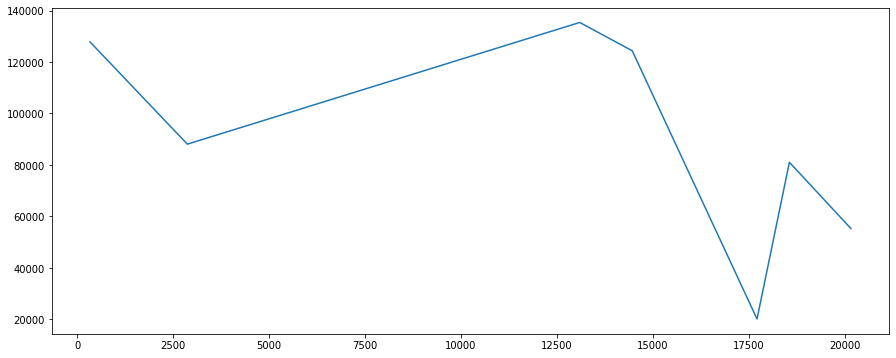

In [ ]:
y.plot(figsize=(15, 6))
plt.show()

In [ ]:

# Create a DataFrame object from list 
series1A = series1
print (series1A[series1A['City'] == 'Little Rock'])



       RegionID  SizeRank  RegionName  ... 2020-01-31 2020-02-29 2020-03-31
2610      89442      2628       72204  ...    75124.0    76106.0    76895.0
3176      89446      3203       72209  ...    73768.0    74577.0    75424.0
3549      89443      3580       72205  ...   162577.0   163100.0   164072.0
3824      89448      3857       72211  ...   193951.0   194172.0   194937.0
3985      89457      4019       72223  ...   337705.0   337720.0   338871.0
4664      89444      4706       72206  ...    78679.0    78858.0    79523.0
6918      89447      6982       72210  ...   182397.0   182941.0   183945.0
7476      89440      7547       72202  ...    97737.0    98556.0    99905.0
7902      89371      7980       72103  ...   124611.0   124476.0   124672.0
8085      89459      8168       72227  ...   190350.0   190541.0   191343.0
8237      89445      8322       72207  ...   300589.0   300816.0   302595.0
8600      89449      8690       72212  ...   285048.0   284712.0   285173.0
18775     75

In [ ]:
seriesLR1.sum(axis = 0, skipna = True) 

2610     19411720.0
3176     18960305.0
3549     38421072.0
3824     49308136.0
3985     86878703.0
4664     19080181.0
6918     44352751.0
7476     27108821.0
7902     30713409.0
8085     48362462.0
8237     65451258.0
8600     69732414.0
18775    12917865.0
19308    64462489.0
24019     4835165.0
24318     3570890.0
dtype: float64

In [ ]:
lr = seriesLR1.mean()

In [ ]:
print (lr)

2610      66478.493151
3176      64932.551370
3549     131579.013699
3824     168863.479452
3985     297529.804795
4664      65343.085616
6918     151892.982877
7476      92838.428082
7902     105182.907534
8085     165624.869863
8237     224148.143836
8600     238809.636986
18775     44239.263699
19308    220761.948630
24019     16558.784247
24318     12229.075342
dtype: float64


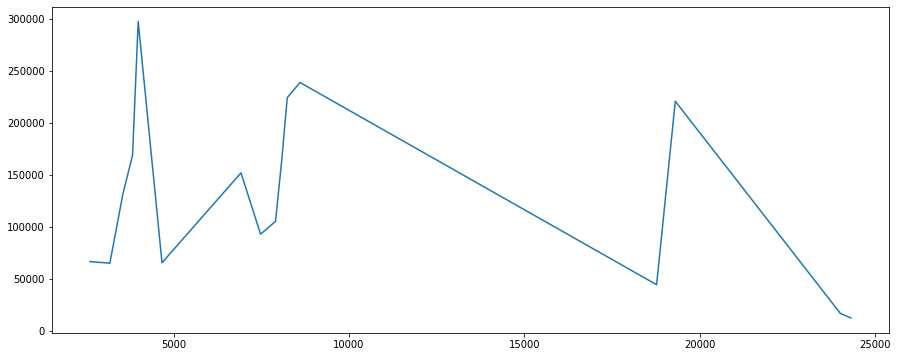

In [ ]:
lr.plot(figsize=(15, 6))
plt.show()

In [ ]:

# Create a DataFrame object from list 
series1A = series1
print (series1A[series1A['Metro'] == 'Fayetteville'])
#print (series1A[series1A['Metro'] == 'Searcy'])

       RegionID  SizeRank  RegionName  ... 2020-01-31 2020-02-29 2020-03-31
214       69849       215       28314  ...   127449.0   127791.0   128149.0
1302      69842      1309       28306  ...   163196.0   163748.0   164245.0
1448      69902      1457       28376  ...   179991.0   180248.0   180527.0
1526      69847      1535       28311  ...   139264.0   139653.0   140037.0
1712      69840      1720       28304  ...   103063.0   103398.0   103748.0
2249      69839      2261       28303  ...   121139.0   121710.0   122495.0
2342      69876      2355       28348  ...   152364.0   152822.0   153268.0
6233      69848      6291       28312  ...   168981.0   169147.0   169419.0
6641      69837      6702       28301  ...    57540.0    57990.0    58720.0
10809     69841     10931       28305  ...   171647.0   172477.0   173241.0
11326     69897     11454       28371  ...   137566.0   138230.0   138981.0
12466     69915     12628       28391  ...   162750.0   163006.0   163410.0
13082     69

In [ ]:
seriesF1 = pd.DataFrame(series1A)
#print (series1A[series1A['Metro'] == 'Fayetteville'])
seriesF1 = seriesF1[seriesF1['Metro'] == 'Fayetteville']
#seriesF1
seriesF1 = seriesF1.drop(['RegionID', 'SizeRank', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName',], axis='columns') 
seriesF1


,RegionName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,...,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31
214,28314,91738.0,91882.0,92086.0,92390.0,92582.0,92777.0,93002.0,93361.0,93667.0,94062.0,94344.0,94595.0,94609.0,94701.0,94652.0,94815.0,94987.0,95121.0,95118.0,95054.0,95101.0,94974.0,94882.0,94768.0,95125.0,95383.0,95670.0,95580.0,95695.0,95871.0,96169.0,96181.0,96051.0,95967.0,96112.0,96403.0,96443.0,96426.0,96466.0,...,116539.0,116882.0,117215.0,117306.0,117783.0,118247.0,118580.0,118518.0,118027.0,117599.0,117211.0,116796.0,116259.0,116023.0,116143.0,116591.0,116638.0,116987.0,117574.0,118617.0,119464.0,120423.0,121155.0,121587.0,121808.0,121910.0,122483.0,122911.0,123722.0,124077.0,124299.0,124389.0,124643.0,124785.0,125022.0,125708.0,126576.0,127449.0,127791.0,128149.0
1302,28306,113111.0,113349.0,113559.0,113716.0,113821.0,113814.0,114056.0,114316.0,114629.0,114971.0,115243.0,115616.0,115788.0,115869.0,115758.0,116118.0,116473.0,116980.0,117024.0,117110.0,116947.0,116650.0,116501.0,116478.0,116953.0,117242.0,117500.0,117400.0,117512.0,117620.0,117875.0,117985.0,118385.0,118981.0,119422.0,119433.0,119038.0,118955.0,119201.0,...,148434.0,148869.0,149281.0,149582.0,150427.0,151230.0,151812.0,151710.0,151262.0,150824.0,150573.0,150049.0,149662.0,149511.0,149954.0,150596.0,150780.0,151292.0,152120.0,153638.0,154752.0,155795.0,156495.0,157128.0,157378.0,157562.0,157954.0,158361.0,159146.0,159475.0,159607.0,159496.0,159711.0,160011.0,160450.0,161232.0,162215.0,163196.0,163748.0,164245.0
1448,28376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,155650.0,156333.0,157067.0,157779.0,158499.0,159236.0,159955.0,160747.0,161499.0,162328.0,163163.0,164122.0,165109.0,166114.0,167136.0,168028.0,168926.0,169641.0,170446.0,171149.0,171931.0,172684.0,173455.0,174357.0,175158.0,175902.0,176364.0,176818.0,177208.0,177695.0,178186.0,178673.0,179091.0,179431.0,179704.0,179780.0,179884.0,179991.0,180248.0,180527.0
1526,28311,99811.0,100214.0,100615.0,101303.0,101855.0,102285.0,102747.0,103114.0,103469.0,103830.0,104216.0,104447.0,104442.0,104333.0,104077.0,103904.0,103656.0,103536.0,103294.0,103322.0,103350.0,103260.0,103082.0,103115.0,103640.0,104146.0,104665.0,104977.0,105576.0,106125.0,106670.0,106853.0,106948.0,107144.0,107310.0,107421.0,107167.0,107053.0,107055.0,...,126318.0,126450.0,126305.0,126370.0,126993.0,127823.0,128346.0,128325.0,128187.0,128138.0,127975.0,127214.0,126396.0,126166.0,126708.0,127277.0,127453.0,127929.0,128929.0,130141.0,130714.0,131384.0,132136.0,132902.0,133370.0,133582.0,134130.0,134647.0,135392.0,135656.0,135627.0,135708.0,136097.0,136413.0,136634.0,137330.0,138309.0,139264.0,139653.0,140037.0
1712,28304,81874.0,81982.0,82197.0,82514.0,82786.0,82986.0,83205.0,83464.0,83676.0,83977.0,84265.0,84514.0,84461.0,84402.0,84205.0,84222.0,84279.0,84435.0,84478.0,84472.0,84493.0,84384.0,84296.0,84192.0,84558.0,84883.0,85252.0,85271.0,85291.0,85245.0,85279.0,85263.0,85273.0,85251.0,85198.0,85252.0,85194.0,85320.0,85406.0,...,92146.0,92180.0,92280.0,92153.0,92607.0,93148.0,93685.0,93607.0,93377.0,93210.0,93087.0,92735.0,92256.0,92229.0,92467.0,

In [ ]:
seriesF1 = seriesF1.T
print (seriesF1)

               214       1302      1448   ...     16554     16634     28438
RegionName   28314.0   28306.0   28376.0  ...   28357.0   28395.0   28342.0
1996-01-31   91738.0  113111.0       NaN  ...       NaN  111102.0       NaN
1996-02-29   91882.0  113349.0       NaN  ...       NaN  111624.0       NaN
1996-03-31   92086.0  113559.0       NaN  ...       NaN  111666.0       NaN
1996-04-30   92390.0  113716.0       NaN  ...       NaN  112542.0       NaN
...              ...       ...       ...  ...       ...       ...       ...
2019-11-30  125708.0  161232.0  179780.0  ...  100634.0  161700.0  113459.0
2019-12-31  126576.0  162215.0  179884.0  ...  100973.0  162261.0  113364.0
2020-01-31  127449.0  163196.0  179991.0  ...  101280.0  162622.0  113231.0
2020-02-29  127791.0  163748.0  180248.0  ...  101556.0  162611.0  113858.0
2020-03-31  128149.0  164245.0  180527.0  ...  101999.0  163197.0  114889.0

[292 rows x 16 columns]


In [ ]:
seriesF1 = seriesF1.fillna(0)


In [ ]:
print(seriesF1)

               214       1302      1448   ...     16554     16634     28438
RegionName   28314.0   28306.0   28376.0  ...   28357.0   28395.0   28342.0
1996-01-31   91738.0  113111.0       0.0  ...       0.0  111102.0       0.0
1996-02-29   91882.0  113349.0       0.0  ...       0.0  111624.0       0.0
1996-03-31   92086.0  113559.0       0.0  ...       0.0  111666.0       0.0
1996-04-30   92390.0  113716.0       0.0  ...       0.0  112542.0       0.0
...              ...       ...       ...  ...       ...       ...       ...
2019-11-30  125708.0  161232.0  179780.0  ...  100634.0  161700.0  113459.0
2019-12-31  126576.0  162215.0  179884.0  ...  100973.0  162261.0  113364.0
2020-01-31  127449.0  163196.0  179991.0  ...  101280.0  162622.0  113231.0
2020-02-29  127791.0  163748.0  180248.0  ...  101556.0  162611.0  113858.0
2020-03-31  128149.0  164245.0  180527.0  ...  101999.0  163197.0  114889.0

[292 rows x 16 columns]


In [ ]:
seriesF1.sum(axis = 0, skipna = True) 

214      32554113.0
1302     40561405.0
1448     27017687.0
1526     35822523.0
1712     27827582.0
2249     31787622.0
2342     38069863.0
6233     40547254.0
6641     17810106.0
10809    42417580.0
11326    31694933.0
12466    37554570.0
13082    44636226.0
16554    19020322.0
16634    41015816.0
28438     6978239.0
dtype: float64

In [ ]:
fa = seriesF1.mean()

In [ ]:
print (fa)

214      111486.688356
1302     138908.921233
1448      92526.325342
1526     122679.873288
1712      95299.938356
2249     108861.719178
2342     130376.243151
6233     138860.458904
6641      60993.513699
10809    145265.684932
11326    108544.291096
12466    128611.541096
13082    152863.787671
16554     65138.089041
16634    140465.123288
28438     23898.078767
dtype: float64


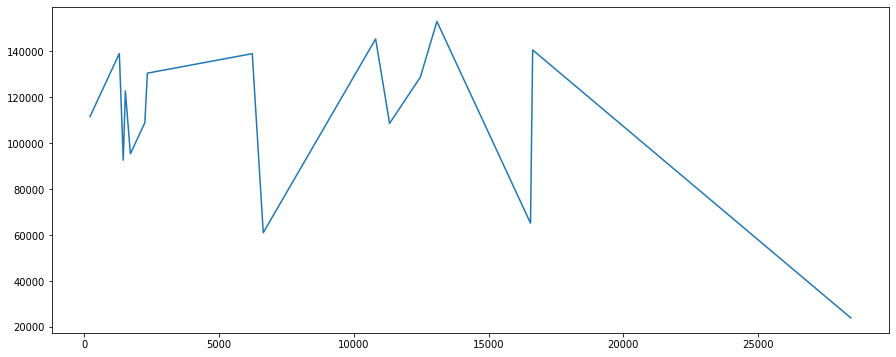

In [ ]:
fa.plot(figsize=(15, 6))
plt.show()

In [ ]:

# Create a DataFrame object from list 
series1A = series1
print (series1A[series1A['Metro'] == 'Searcy'])

       RegionID  SizeRank  RegionName  ... 2020-01-31 2020-02-29 2020-03-31
2445      89409      2461       72143  ...   137024.0   136435.0   136386.0
8294      89298      8379       72012  ...   129146.0   128691.0   128663.0
10702     89359     10824       72081  ...    97242.0    96910.0    96980.0
11674     89296     11816       72010  ...    84213.0    83769.0    83471.0
14311     89305     14540       72020  ...    64680.0    64703.0    64966.0
16288     89388     16617       72121  ...   117834.0   117513.0   117597.0
16373     89370     16711       72102  ...    95898.0    95826.0    95984.0
17034     89404     17416       72137  ...   121884.0   121781.0   121875.0
18578     89360     19153       72082  ...    46872.0    46779.0    46706.0
19101     89403     19737       72136  ...   124385.0   124180.0   124430.0
21013     89330     21916       72045  ...   148768.0   148509.0   148897.0
24294     89341     25722       72060  ...    72218.0    72291.0    72383.0
24411     89

In [ ]:
seriesS1 = pd.DataFrame(series1A)
#print (series1A[series1A['Metro'] == 'Searcy'])
seriesS1 = seriesS1[seriesS1['Metro'] == 'Searcy']
#seriesS1
seriesS1 = seriesS1.drop(['RegionID', 'SizeRank', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName',], axis='columns') 
seriesS1


,RegionName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,...,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31
2445,72143,75061.0,75016.0,75024.0,75013.0,75034.0,75071.0,75144.0,75244.0,75365.0,75516.0,75752.0,76024.0,76281.0,76540.0,76785.0,77035.0,77219.0,77345.0,77522.0,77688.0,77858.0,78028.0,78242.0,78527.0,78586.0,78685.0,78781.0,79229.0,79800.0,80446.0,80932.0,81429.0,81951.0,82506.0,82792.0,82918.0,83563.0,84225.0,84799.0,...,130252.0,130737.0,131163.0,131532.0,131886.0,132263.0,132545.0,132895.0,133536.0,134163.0,134681.0,135214.0,136040.0,136673.0,136922.0,136917.0,137072.0,137194.0,137124.0,137041.0,137750.0,138352.0,139054.0,139838.0,141469.0,142570.0,142850.0,142389.0,142374.0,142341.0,142660.0,142838.0,142174.0,141541.0,140831.0,140000.0,138321.0,137024.0,136435.0,136386.0
8294,72012,71933.0,71940.0,71984.0,72025.0,72060.0,72094.0,72113.0,72168.0,72233.0,72311.0,72428.0,72599.0,72850.0,73166.0,73525.0,73945.0,74235.0,74433.0,74502.0,74638.0,74752.0,75014.0,75298.0,75683.0,76324.0,76656.0,76647.0,76257.0,76316.0,76613.0,77164.0,77580.0,78063.0,78278.0,78333.0,78077.0,77262.0,76888.0,76946.0,...,122937.0,123371.0,123658.0,123911.0,124134.0,124465.0,124735.0,125153.0,125760.0,126277.0,126615.0,126988.0,127706.0,128306.0,128626.0,128669.0,128819.0,128889.0,128854.0,128697.0,129359.0,129827.0,130484.0,131178.0,132690.0,133613.0,133760.0,133351.0,133477.0,133573.0,133879.0,134108.0,133513.0,133045.0,132452.0,131770.0,130253.0,129146.0,128691.0,128663.0
10702,72081,56956.0,56882.0,56823.0,56730.0,56674.0,56576.0,56499.0,56528.0,56612.0,56674.0,56589.0,56609.0,56739.0,56990.0,57198.0,57447.0,57607.0,57758.0,57799.0,57901.0,58069.0,58278.0,58547.0,58745.0,58898.0,59050.0,59289.0,59575.0,59861.0,60432.0,60917.0,61135.0,61144.0,61461.0,62186.0,62661.0,62779.0,62496.0,62222.0,...,91435.0,92014.0,92408.0,92788.0,93033.0,93380.0,93536.0,93758.0,94247.0,94767.0,95066.0,95314.0,95807.0,96073.0,96157.0,96022.0,96246.0,96440.0,96558.0,96659.0,97201.0,97665.0,98242.0,99000.0,100390.0,101203.0,101406.0,101075.0,101076.0,101075.0,101268.0,101367.0,100903.0,100459.0,99975.0,99351.0,98085.0,97242.0,96910.0,96980.0
11674,72010,54860.0,54759.0,54764.0,54726.0,54664.0,54446.0,54183.0,54166.0,54306.0,54543.0,54671.0,54819.0,54956.0,55094.0,55326.0,55592.0,55861.0,55882.0,55979.0,55980.0,56169.0,56374.0,56702.0,57058.0,57455.0,57907.0,58047.0,58090.0,58319.0,59460.0,60815.0,61862.0,62265.0,62402.0,62601.0,62747.0,62874.0,63182.0,63454.0,...,77216.0,77400.0,77497.0,77606.0,77945.0,78463.0,78874.0,79288.0,79675.0,80227.0,80652.0,81125.0,81494.0,82070.0,82529.0,82859.0,82967.0,82970.0,82881.0,82828.0,83308.0,83666.0,84225.0,84737.0,85703.0,86253.0,86490.0,86475.0,86681.0,86742.0,87027.0,87211.0,86964.0,86678.0,86224.0,85744.0,84888.0,84213.0,83769.0,83471.0
14311,72020,46080.0,45962.0,45902.0,45761.0,45690.0,45703.0,45721.0,45916.0,46052.0,46291.0,46510.0,46712.0,47223.0,47685.0,48083.0,47900.0,47653.0,47593.0,47757.0,47850.0,47887.0,47983.0,48113.0,48314.0,48017.0,47889.0,47976.0,49032.0,50171.0,50824.0,51410.0,51657.0,52250.0,52541.0,52868.0,53269.0,53917.0,54632.0,55130.0,...,59532.0,59020.0,58845.0,58816.0,59176.0,59337.0,59699.0,60125.0,60605.0,60938.0,60837.0,61054.0,61314.0,619

In [ ]:
seriesS1 = seriesS1.T
print (seriesS1)

               2445      8294     10702  ...    29275    29366    30097
RegionName   72143.0   72012.0  72081.0  ...  72052.0  72165.0  72178.0
1996-01-31   75061.0   71933.0  56956.0  ...      NaN      NaN      NaN
1996-02-29   75016.0   71940.0  56882.0  ...      NaN      NaN      NaN
1996-03-31   75024.0   71984.0  56823.0  ...      NaN      NaN      NaN
1996-04-30   75013.0   72025.0  56730.0  ...      NaN      NaN      NaN
...              ...       ...      ...  ...      ...      ...      ...
2019-11-30  140000.0  131770.0  99351.0  ...  32244.0  59194.0  41452.0
2019-12-31  138321.0  130253.0  98085.0  ...  31984.0  59691.0  41032.0
2020-01-31  137024.0  129146.0  97242.0  ...  31919.0  60046.0  40543.0
2020-02-29  136435.0  128691.0  96910.0  ...  31984.0  60681.0  40114.0
2020-03-31  136386.0  128663.0  96980.0  ...  32203.0  61563.0  39782.0

[292 rows x 18 columns]


In [ ]:
seriesS1 = seriesS1.fillna(0)


In [ ]:
print(seriesS1)

               2445      8294     10702  ...    29275    29366    30097
RegionName   72143.0   72012.0  72081.0  ...  72052.0  72165.0  72178.0
1996-01-31   75061.0   71933.0  56956.0  ...      0.0      0.0      0.0
1996-02-29   75016.0   71940.0  56882.0  ...      0.0      0.0      0.0
1996-03-31   75024.0   71984.0  56823.0  ...      0.0      0.0      0.0
1996-04-30   75013.0   72025.0  56730.0  ...      0.0      0.0      0.0
...              ...       ...      ...  ...      ...      ...      ...
2019-11-30  140000.0  131770.0  99351.0  ...  32244.0  59194.0  41452.0
2019-12-31  138321.0  130253.0  98085.0  ...  31984.0  59691.0  41032.0
2020-01-31  137024.0  129146.0  97242.0  ...  31919.0  60046.0  40543.0
2020-02-29  136435.0  128691.0  96910.0  ...  31984.0  60681.0  40114.0
2020-03-31  136386.0  128663.0  96980.0  ...  32203.0  61563.0  39782.0

[292 rows x 18 columns]


In [ ]:
seriesS1 = seriesS1.fillna(0)


In [ ]:
print(seriesS1)

               2445      8294     10702  ...    29275    29366    30097
RegionName   72143.0   72012.0  72081.0  ...  72052.0  72165.0  72178.0
1996-01-31   75061.0   71933.0  56956.0  ...      0.0      0.0      0.0
1996-02-29   75016.0   71940.0  56882.0  ...      0.0      0.0      0.0
1996-03-31   75024.0   71984.0  56823.0  ...      0.0      0.0      0.0
1996-04-30   75013.0   72025.0  56730.0  ...      0.0      0.0      0.0
...              ...       ...      ...  ...      ...      ...      ...
2019-11-30  140000.0  131770.0  99351.0  ...  32244.0  59194.0  41452.0
2019-12-31  138321.0  130253.0  98085.0  ...  31984.0  59691.0  41032.0
2020-01-31  137024.0  129146.0  97242.0  ...  31919.0  60046.0  40543.0
2020-02-29  136435.0  128691.0  96910.0  ...  31984.0  60681.0  40114.0
2020-03-31  136386.0  128663.0  96980.0  ...  32203.0  61563.0  39782.0

[292 rows x 18 columns]


In [ ]:
seriesS1.sum(axis = 0, skipna = True) 

2445     31632045.0
8294     29825955.0
10702    22222146.0
11674    19783171.0
14311    15634239.0
16288    26786749.0
16373    21521108.0
17034    25282117.0
18578     6638818.0
19101    28421716.0
21013    20680452.0
24294    16864225.0
24411    17958174.0
28229     9784956.0
28495     8217737.0
29275     5635433.0
29366    10949795.0
30097     5054166.0
dtype: float64

In [ ]:
s = seriesS1.mean()

In [ ]:
print (s)

2445     108328.921233
8294     102143.681507
10702     76103.239726
11674     67750.585616
14311     53541.914384
16288     91735.441781
16373     73702.424658
17034     86582.592466
18578     22735.678082
19101     97334.643836
21013     70823.465753
24294     57754.195205
24411     61500.595890
28229     33510.123288
28495     28142.934932
29275     19299.428082
29366     37499.297945
30097     17308.787671
dtype: float64


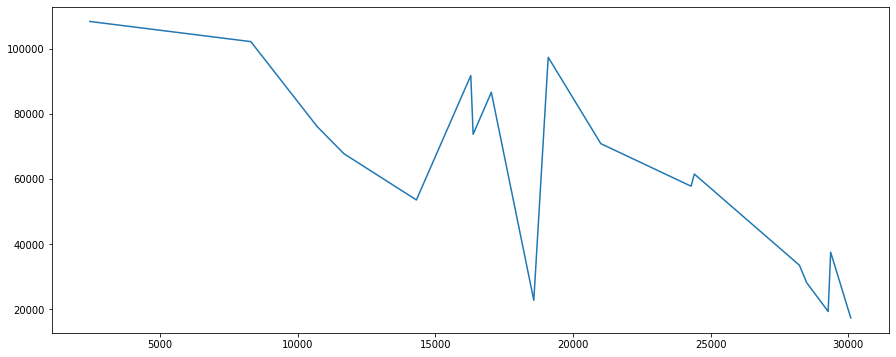

In [ ]:
s.plot(figsize=(15, 6))
plt.show()

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
#seriesHS1.index = pd.to_datetime(seriesHS1.index)
parse_dates['DATE'] = seriesHS1['DATE'].dt.strftime('%Y%m%d')
decomposition = sm.tsa.seasonal_decompose(seriesHS1, model='additive')
fig = decomposition.plot()
plt.show()

KeyError: ignored

In [ ]:
print (seriesHS1)

               331       2868      13095     14464    17716    18560     20163
RegionName   71913.0   71901.0   71968.0   71964.0  71956.0  71949.0   71933.0
1996-01-31   91204.0   56746.0   95089.0   78239.0      0.0  71456.0       0.0
1996-02-29   90258.0   56160.0   94846.0   77565.0      0.0  70979.0       0.0
1996-03-31   90182.0   56154.0   95517.0   78194.0      0.0  69888.0       0.0
1996-04-30   90125.0   56047.0   96464.0   78844.0      0.0  68562.0       0.0
...              ...       ...       ...       ...      ...      ...       ...
2019-11-30  161806.0  125741.0  176282.0  163294.0  75018.0  95600.0  137149.0
2019-12-31  162347.0  126252.0  177930.0  164107.0  76052.0  96312.0  138163.0
2020-01-31  163134.0  126854.0  179789.0  165067.0  76815.0  96171.0  138781.0
2020-02-29  164485.0  128023.0  182266.0  166484.0  77365.0  96568.0  140289.0
2020-03-31  166238.0  129745.0  184162.0  167870.0  78301.0  97842.0  141090.0

[292 rows x 7 columns]


In [ ]:
sHS1 = pd.series(seriesHS1) 
#seriesHS1= seriesHS1.set_index('RegionName')
#n_seriesHS1 = seriesHS1.loc[1:, '%Y%b%d']
#raw_data['Mycol'] =  pd.to_datetime(raw_data['Mycol'], format='%d%b%Y:%H:%M:%S.%f')
#data.loc[:,'2008q3':'2009q2']

AttributeError: ignored

## Start Exploratory Data Analysis (EDA)

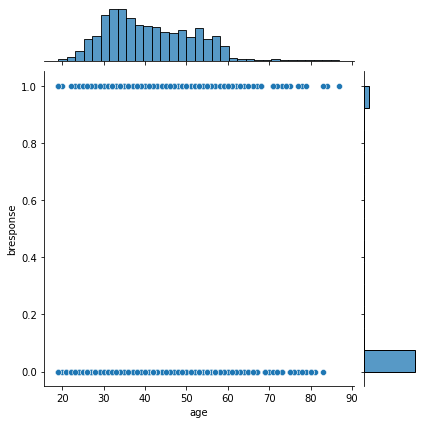

In [ ]:
sns.jointplot(x="age", y="bresponse", data=cellwork)





/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


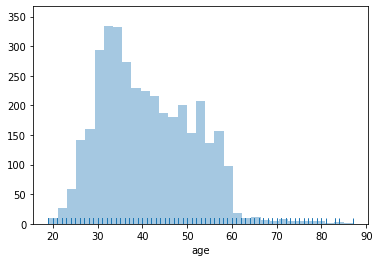

In [ ]:
sns.distplot(cellwork['age'], kde=False, rug=True);


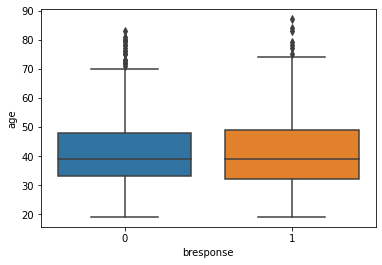

In [ ]:
sns.boxplot(x="bresponse", y="age", data=cellwork)




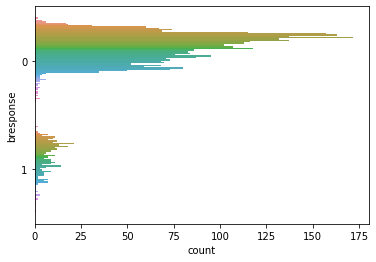

In [ ]:
ax = sns.countplot(y="bresponse", data=cellwork,
             hue="age")

ax.legend_.remove()
# sns.xlabel=("Customer Count")
# sns.ylabel=("Customers who switch")
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 83.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


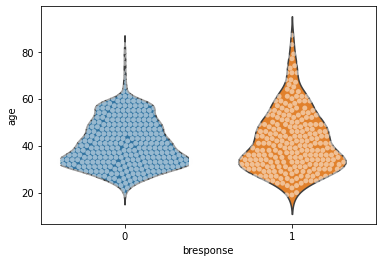

In [ ]:
# MORE INTENSIVE PLOTS - SWARM & VIOLIN

#sns.swarmplot(x="bresponse", y="age", data=cellwork)
#sns.plt.show()

sns.violinplot(x="bresponse", y="age", data=cellwork, inner=None)
sns.swarmplot(x="bresponse", y="age", data=cellwork, color="w", alpha=.5)
plt.show()


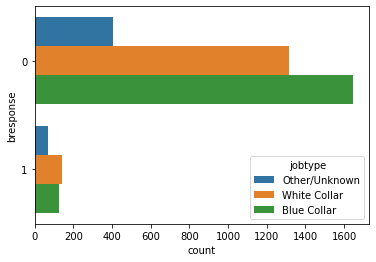

In [ ]:
sns.countplot(y="bresponse", data=cellwork,
             hue="jobtype")
sns.xlabel=("Customer Count")
sns.ylabel=("Customers who switch")
plt.show()



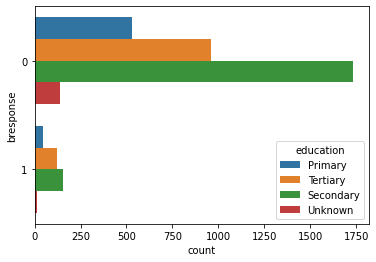

In [ ]:
sns.countplot(y="bresponse", data=cellwork,
             hue="education")
sns.xlabel=("Customer Count")
sns.ylabel=("Customers who switch")
plt.show()



## Another deviation between response ratios

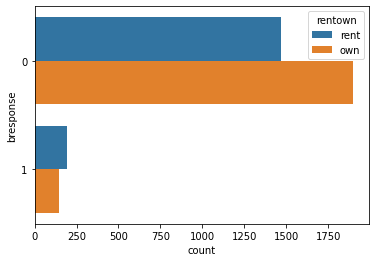

In [ ]:
sns.countplot(y="bresponse", data=cellwork,
             hue="rentown")
sns.xlabel=("Customer Count")
sns.ylabel=("Customers who switch")
plt.show()

## End EDA



## Start Code Review

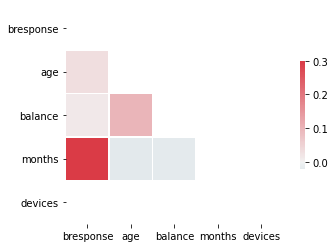

In [ ]:
corr = cellwork.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
#f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

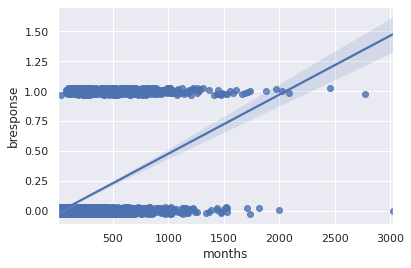

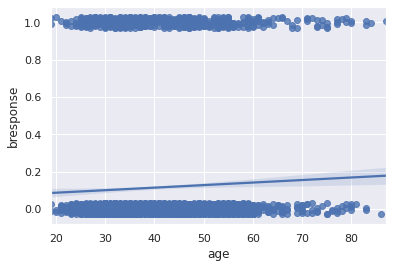

In [ ]:
# QUICK SCATTER PLOT TO LOOK AT RELATIONSHIP BETWEEN VARIABLES

sns.set(color_codes=True)

sns.regplot(x="months", y="bresponse", data=cell, y_jitter=0.03)
plt.show()

sns.regplot(x="age", y="bresponse", data=cell, y_jitter=0.03)
plt.show()



In [ ]:
# HOW MIGHT WE LOOK AT ACCOUNT BALANCE AND RESPONSE

# sns.regplot(x="balance", y="bresponse", data=cell, y_jitter=0.03)

# HOW MIGHT WE LOOK AT RENT/OWN VERSUS RESPONSE

#plt.show()

In [ ]:
print(cellwork.describe())
#print(cell['loan'])

print(cell.pivot_table(['age'], index = ['bresponse']))
print(cell.pivot_table(['devices'], index = ['bresponse']))
print(cell.pivot_table(['months'], index = ['bresponse']))
#print(cellwork.pivot_table(['repairplan'], index = ['bresponse']))
#print(cell.pivot_table(['rentown'], index = ['bresponse']))


         bresponse          age       balance       months  devices
count  3705.000000  3705.000000   3705.000000  3705.000000   3705.0
mean      0.090958    41.083671   1374.862078   262.103104      1.0
std       0.287588    10.373818   3008.524207   262.937329      0.0
min       0.000000    19.000000  -3313.000000     4.000000      1.0
25%       0.000000    33.000000     60.000000   102.000000      1.0
50%       0.000000    39.000000    415.000000   180.000000      1.0
75%       0.000000    49.000000   1412.000000   327.000000      1.0
max       1.000000    87.000000  71188.000000  3025.000000      1.0
                 age
bresponse           
0          40.998000
1          42.491363
            devices
bresponse          
0          1.471250
1          2.090211
               months
bresponse            
0          226.347500
1          552.742802


In [ ]:

# examine descriptive statistics and frequency tables for variables in model
print(cellwork.describe())
print('\njobtype:\n',cellwork['jobtype'].value_counts())
print('\nmarital:\n',cellwork['marital'].value_counts())
print('\neducation:\n',cellwork['education'].value_counts())
print('\ndefault:\n',cellwork['default'].value_counts())
print('\nhousing:\n',cellwork['rentown'].value_counts())
#print('\nloan:\n',cellwork['loan'].value_counts())


         bresponse          age       balance       months  devices
count  3705.000000  3705.000000   3705.000000  3705.000000   3705.0
mean      0.090958    41.083671   1374.862078   262.103104      1.0
std       0.287588    10.373818   3008.524207   262.937329      0.0
min       0.000000    19.000000  -3313.000000     4.000000      1.0
25%       0.000000    33.000000     60.000000   102.000000      1.0
50%       0.000000    39.000000    415.000000   180.000000      1.0
75%       0.000000    49.000000   1412.000000   327.000000      1.0
max       1.000000    87.000000  71188.000000  3025.000000      1.0

jobtype:
 Blue Collar      1776
White Collar     1453
Other/Unknown     476
Name: jobtype, dtype: int64

marital:
 Married     2305
Single       957
Divorced     443
Name: marital, dtype: int64

education:
 Secondary    1891
Tertiary     1084
Primary       580
Unknown       150
Name: education, dtype: int64

default:
 No     3634
Yes      71
Name: default, dtype: int64

housing:
 own 

In [ ]:

# examine means of continuous explanatory variables by response
print(cellwork.pivot_table(['age'], index = ['bresponse']))
print(cellwork.pivot_table(['balance'], index = ['bresponse']))


                 age
bresponse           
0          40.983076
1          42.089021
               balance
bresponse             
0          1359.654097
1          1526.851632


In [ ]:
# baseline response rate computed (will be used later)
filter_took_offer = cellwork['bresponse'].map(lambda d: d == 1)
baseline_response_rate = len(cellwork[filter_took_offer]) / len(cellwork)
print('\nBaseline proportion of clients responding to offer: ',\
    round(baseline_response_rate,5), '\n')


Baseline proportion of clients responding to offer:  0.09096 



In [ ]:

# examine proportion responding across levels 
# of categorical variables
print(cellwork.pivot_table(['bresponse'], index = ['jobtype']))
print(cellwork.pivot_table(['bresponse'], index = ['education']))
print(cellwork.pivot_table(['bresponse'], index = ['marital']))
print(cellwork.pivot_table(['bresponse'], index = ['default']))
print(cellwork.pivot_table(['bresponse'], index = ['rentown']))
#print(cellwork.pivot_table(['bresponse'], index = ['repairplan']))


               bresponse
jobtype                 
Blue Collar     0.072072
Other/Unknown   0.144958
White Collar    0.096352
           bresponse
education           
Primary     0.082759
Secondary   0.082496
Tertiary    0.112546
Unknown     0.073333
          bresponse
marital            
Divorced   0.126411
Married    0.073753
Single     0.115987
         bresponse
default           
No        0.090534
Yes       0.112676
         bresponse
rentown           
own       0.069995
rent      0.116727


## LOGIT MODEL FOR SWITCH

Optimization terminated successfully.
         Current function value: 0.295795
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              bresponse   No. Observations:                 3705
Model:                          Logit   Df Residuals:                     3693
Method:                           MLE   Df Model:                           11
Date:                Wed, 14 Oct 2020   Pseudo R-squ.:                 0.02938
Time:                        18:24:46   Log-Likelihood:                -1095.9
converged:                       True   LL-Null:                       -1129.1
Covariance Type:            nonrobust   LLR p-value:                 5.996e-10
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.9029      0.371     -7.815      0.000      -3.631

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


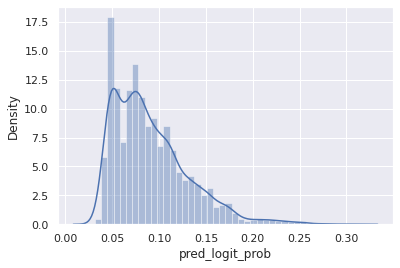

In [ ]:
# specify model for logisitc regression
cell = 'bresponse ~ age + jobtype + education + marital +\
    default + balance + rentown'

# ----------------------------------
# fit logistic regression model 
# ----------------------------------
# convert R-like formula into design matrix needed for statsmodels        
y,x = patsy.dmatrices(cell, cellwork, return_type = 'dataframe')    

my_logit_model = sm.Logit(y,x)
# fit the model to the full data set
my_logit_model_fit = my_logit_model.fit()
print(my_logit_model_fit.summary())

# predicted probability of reponding to the offer
cellwork['pred_logit_prob'] = my_logit_model_fit.predict(linear = False)

sns.distplot(cellwork['pred_logit_prob'])

## End Code Review